# Pipeline for the anomaly detection on the SKAB using ARIMA fault detection algorithm

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

The idea behind this algorithm is to use ARIMA weights as features for the anomaly detection algorithm. Using discrete differences of weight coefficients for different heuristic methods for obtaining function, which characterized the state (anomaly, not anomaly) using a threshold. 

Links at [PyPi](https://pypi.org/project/arimafd/), [GitHub](https://github.com/waico/arimafd) and [paper](https://waico.ru)

In [1]:
# libraries importing
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import pickle
from itertools import product
from sympy import diff, symbols, sympify, Symbol, poly
from time import time
import matplotlib.gridspec as gridspec

# additional modules
import sys
sys.path.append('../algorithms')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data

Put the `data` folder from the SKAB repository in the root of this repository. So the path will be following: `../data/`. Or select your own path.

In [2]:
path_to_data = '../data/'

## Data loading

In [3]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [4]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

### Data description

In [5]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0


### Data visualization

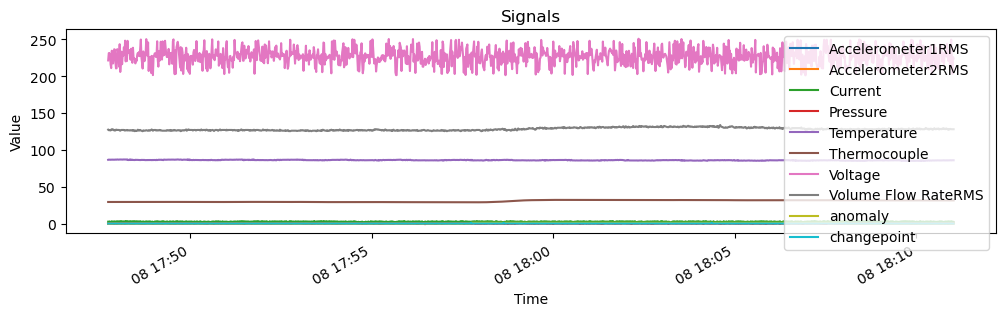

In [6]:
# random dataset visualizing
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

### Labels visualization

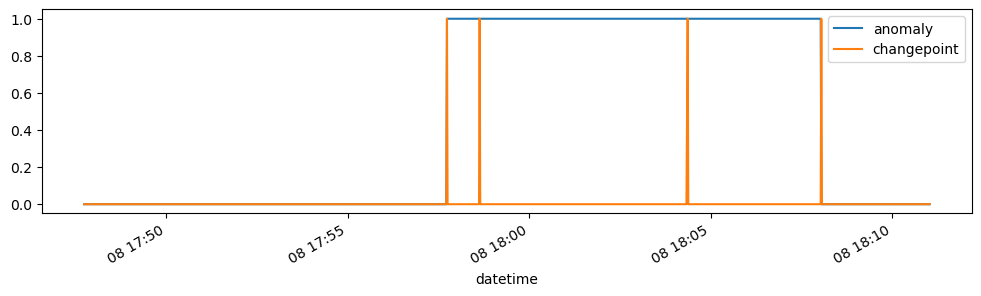

In [7]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [7]:
from arimafd import *
import os

In [8]:
if os.path.exists(r'tensors.pickle'):
    with open(r'tensors.pickle', 'rb') as f:
        tensors = pickle.load(f)
else:
    tensors = []
    for df in list_of_df:
        a = Anomaly_detection(df.iloc[:,:-2])
        tensors.append(a.generate_tensor(ar_order=100))
    with open(r'tensors.pickle', 'wb') as handle:
        pickle.dump(tensors, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [28]:
metrics = range(1,6)
windows= [20,50,100,150]
window_insensitivitys = [20,50,100,150]
history = []
from tsad.evaluating.evaluating import evaluating 

for No_metric,window,window_insensitivity in product(metrics,windows,window_insensitivitys):
    print('XXX',No_metric,window,window_insensitivity)
    predicted_cp=[]
    predicted_cp1 = []
    for i,df in enumerate(list_of_df):
        acci = df.changepoint
        a = Anomaly_detection(df)
        a.tensor = tensors[i]
        a.proc_tensor(No_metric=No_metric, window=window, window_insensitivity=window_insensitivity)
        predicted_cp.append(a.bin_metric)
    nab = evaluating(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    history.append([No_metric, window, window_insensitivity, nab['Standart'], nab['LowFP'], nab['LowFN']])
    print(history)
    print()
    print()
history = pd.DataFrame(history, columns=['No_metric','window','window_insensitivity','Standart','LowFP','LowFN'])

XXX 1 20 20
Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:43'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:44'))
Standart  -  0.09
LowFP  -  -1.53
LowFN  -  0.94
[[1, 20, 20, 0.09, -1.53, 0.94]]




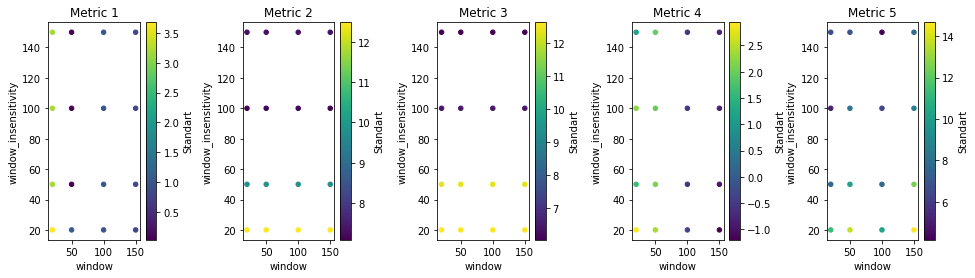

In [11]:
f = plt.figure(figsize=(16,4))
grid = gridspec.GridSpec(1, len(metrics),wspace =0.7)
for i in metrics:
    globals()['ax'+str(i)] = f.add_subplot(grid[i-1])
    history[history.No_metric==i].plot.scatter(x='window',y='window_insensitivity', c='Standart', colormap='viridis',ax=globals()['ax'+str(i)])
    globals()['ax'+str(i)].set_title(f"Metric {i}")
    
plt.show()

In [12]:
No_metric= 5
window= 150
window_insensitivity = 20

predicted_cp=[]
for i,df in enumerate(list_of_df):
    acci = df.changepoint
    a = Anomaly_detection(df)
    a.tensor = tensors[i]
    a.proc_tensor(No_metric=No_metric,window=window, window_insensitivity=window_insensitivity)
    predicted_cp.append(a.bin_metric)

### Results visualization

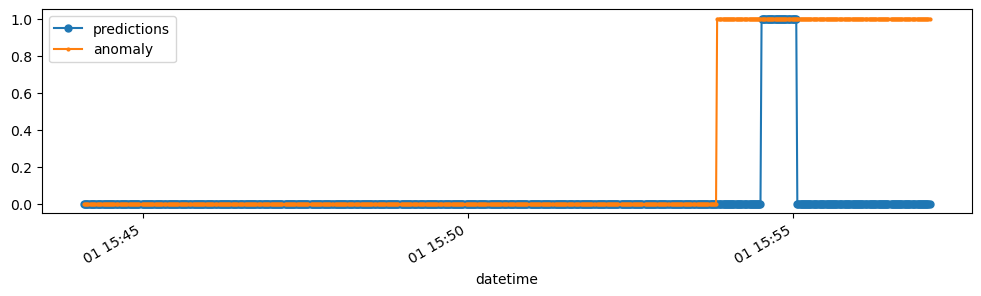

In [13]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

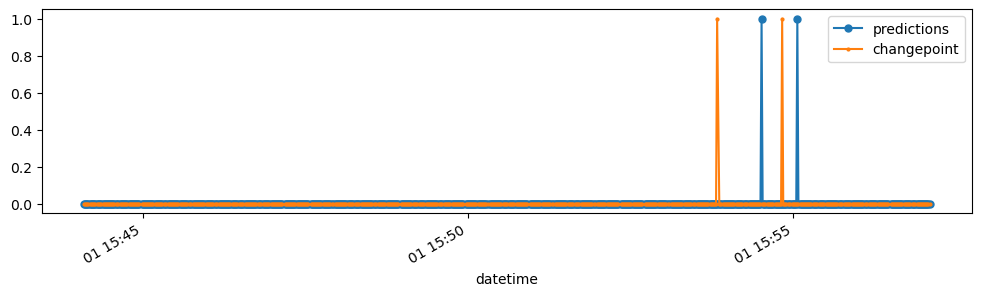

In [14]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Evaluation (metrics calculation)

In [15]:
# 'pip install tsad' if needed
from tsad.evaluating.evaluating import evaluating

### Binary classification (outlier detection) metrics

In [16]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 4.66 %
Missing Alarm Rate 37.02 %
F1 metric 0.73


### Changepoint detection metrics

In [17]:
# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:02:23.600000'), Timestamp('2020-02-08 17:58:38'))
Intersection of scoring windows(Timestamp('2020-02-08 18:09:01.600000'), Timestamp('2020-02-08 18:08:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:24:52.800000'), Timestamp('2020-02-08 18:20:46'))
Intersection of scoring windows(Timestamp('2020-02-08 18:31:06.800000'), Timestamp('2020-02-08 18:28:37'))
Intersection of scoring windows(Timestamp('2020-02-08 18:48:51.600000'), Timestamp('2020-02-08 18:46:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:55:37.600000'), Timestamp('2020-02-08 18:51:55'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:15.800000'), Timestamp('2020-02-08 18:58:30'))
Intersection of scoring windows(Timestamp('2020-02-08 19:06:15.800000'), Timestamp('2020-02-08 19:03:36'))
Intersection of scoring windows(Timestamp('2

In [18]:
# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:43'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:44'))
Standart  -  4.62
LowFP  -  2.01
LowFN  -  6.18
